# Final Project
## CSCE 633
## Arya Rahmanian
## Summer 2024

### Load Dataset

In [1]:
import pandas as pd

#load data
train_df = pd.read_csv("yelp_review_train.csv")
test_df = pd.read_csv("yelp_review_test.csv")

#randomly select data points for training, validation, and testing
train_data = train_df.sample(n=10000, random_state=42)
val_data = train_df.drop(train_data.index).sample(n=1000, random_state=42)
test_data = test_df.sample(n=2000, random_state=42)

print(train_data.head())
#print(val_data.head())
print(test_data.head())


                                                     text  stars
117921  This was a tough one.  After having heard good...    3.0
117777  I have been here probably 3 times in the last ...    3.0
172811  I don't usually do chain restaurants, but I st...    4.0
63245   This place is just out there... There main onl...    1.0
87607   Went here for Happy Hour one evening. Twas a g...    4.0
                                                    text  stars
13742  Sadly I tried chipotle again after the last re...    3.0
12304  This place sells really good fresh corn tortil...    4.0
6107   Having only recently moved to PA, I'm still ge...    4.0
2796   This is by far my favorite breakfast spot in N...    5.0
3379   This is a great store. I come here often, ever...    5.0


In [2]:
import numpy as np

def load_glove_embeddings(file_path):
    embedding_dict = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            embedding_dict[word] = vector
    return embedding_dict


glove_file = 'glove.twitter.27B.200d.txt'  

embedding_dict = load_glove_embeddings(glove_file)

### Data Pre-Processing

In [5]:
def map_labels(stars):
    return 0 if stars < 4 else 1

# create our label column
train_data['label'] = train_data['stars'].apply(map_labels)
test_data['label'] = test_data['stars'].apply(map_labels)
val_data['label'] = val_data['stars'].apply(map_labels)


In [6]:
import re
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

#function to preprocess text
def preprocess_text(text):
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove stop words
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

train_data['text'] = train_data['text'].apply(preprocess_text)
val_data['text'] = val_data['text'].apply(preprocess_text)
test_data['text'] = test_data['text'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Airsight\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Tokenize and Pad Text Vectors

In [42]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['text'])

train_sequences = tokenizer.texts_to_sequences(train_data['text'])
val_sequences = tokenizer.texts_to_sequences(val_data['text'])
test_sequences = tokenizer.texts_to_sequences(test_data['text'])

# max length for sequences
max_length = 300

pad_last_words = True
if(pad_last_words):
    # Pad the last n characters
    train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='pre')
    val_padded = pad_sequences(val_sequences, maxlen=max_length, padding='post', truncating='pre')
    test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='pre')
else:
    # Pad the first n characters
    train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
    val_padded = pad_sequences(val_sequences, maxlen=max_length, padding='post', truncating='post')
    test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

# shape of padded sequences
print(train_padded.shape)
print(val_padded.shape)
print(test_padded.shape)

(10000, 300)
(1000, 300)
(2000, 300)


In [44]:
import torch
# Create embedding matrix
vocab_size = len(tokenizer.word_index) + 1
embed_dim = 200  # GloVe dimension
embedding_matrix = np.zeros((vocab_size, embed_dim))

for word, index in tokenizer.word_index.items():
    if index >= vocab_size:
        continue
    embedding_vector = embedding_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

# Convert embedding matrix to tensor
embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)


### Build Model

#### Model Architecture

In [92]:
import torch.nn as nn

class TransformerSentimentClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, hidden_dim, num_layers, num_classes, max_length, embedding_matrix):
        super(TransformerSentimentClassifier, self).__init__()
        
        # embedding layer
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        
        # positional encoding
        self.positional_encoding = nn.Parameter(torch.zeros(1, max_length, embed_dim))
        
        # transformer encoder layers
        encoder_layers = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=hidden_dim)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)

        #self.dropout = nn.Dropout(0.5)
        
        self.fc = nn.Linear(embed_dim, num_classes)
        
    def forward(self, x):
        x = self.embedding(x)  # (batch_size, max_length, embed_dim)
        x += self.positional_encoding[:, :x.size(1), :]
        
        x = x.permute(1, 0, 2) 
        x = self.transformer_encoder(x)  # (max_length, batch_size, embed_dim)
        
        x = x.mean(dim=0)  # (batch_size, embed_dim)
        x = self.fc(x)  # (batch_size, num_classes)
        return x


#### Hyper-params

In [79]:
import torch.nn.functional as F

embed_dim = 200
num_heads = 8
hidden_dim = 512
num_layers = 4
num_classes = 2 

# Initialize the model
model = TransformerSentimentClassifier(vocab_size, embed_dim, num_heads, hidden_dim, num_layers, num_classes, max_length, embedding_matrix)

# Display the model
print(model)

TransformerSentimentClassifier(
  (embedding): Embedding(30165, 200)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=200, out_features=200, bias=True)
        )
        (linear1): Linear(in_features=200, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=200, bias=True)
        (norm1): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=200, out_features=2, bias=True)
)


C:\Users\Airsight\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


#### Build Dataloaders

In [82]:
from torch.utils.data import Dataset, TensorDataset, DataLoader
BATCH_SIZE = 32

# convert to Torch tensors
X_train = torch.tensor(train_padded, dtype=torch.long)
y_train = torch.tensor(train_data['label'].values, dtype=torch.long)
X_val = torch.tensor(val_padded, dtype=torch.long)
y_val = torch.tensor(val_data['label'].values, dtype=torch.long)
X_test = torch.tensor(test_padded, dtype=torch.long)
y_test = torch.tensor(test_data['label'].values, dtype=torch.long)


train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### Training

In [85]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW, Adam, SGD
from sklearn.model_selection import train_test_split

# lists to store training metrics
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# constants hyper params
EPOCHS = 4
LEARNING_RATE = 0.0001

# init optimizer, and loss function
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

TransformerSentimentClassifier(
  (embedding): Embedding(30165, 200)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=200, out_features=200, bias=True)
        )
        (linear1): Linear(in_features=200, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=200, bias=True)
        (norm1): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=200, out_features=2, bias=True)
)

#### Training Loop

In [88]:
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        
        _, preds = torch.max(outputs, 1)
        correct_predictions += (preds == labels).sum().item()
        total_predictions += labels.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = correct_predictions / total_predictions
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

    # validation
    model.eval()
    val_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            
            _, preds = torch.max(outputs, 1)
            correct_predictions += (preds == labels).sum().item()
            total_predictions += labels.size(0)
    
    val_loss /= len(val_loader.dataset)
    val_accuracy = correct_predictions / total_predictions
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

Epoch 1/4, Loss: 0.3932, Accuracy: 0.8227
Validation Loss: 0.3078, Validation Accuracy: 0.8640
Epoch 2/4, Loss: 0.3044, Accuracy: 0.8736
Validation Loss: 0.3047, Validation Accuracy: 0.8660
Epoch 3/4, Loss: 0.2640, Accuracy: 0.8923
Validation Loss: 0.2776, Validation Accuracy: 0.8850
Epoch 4/4, Loss: 0.1949, Accuracy: 0.9215
Validation Loss: 0.3031, Validation Accuracy: 0.8810


### Plot Training Metrics

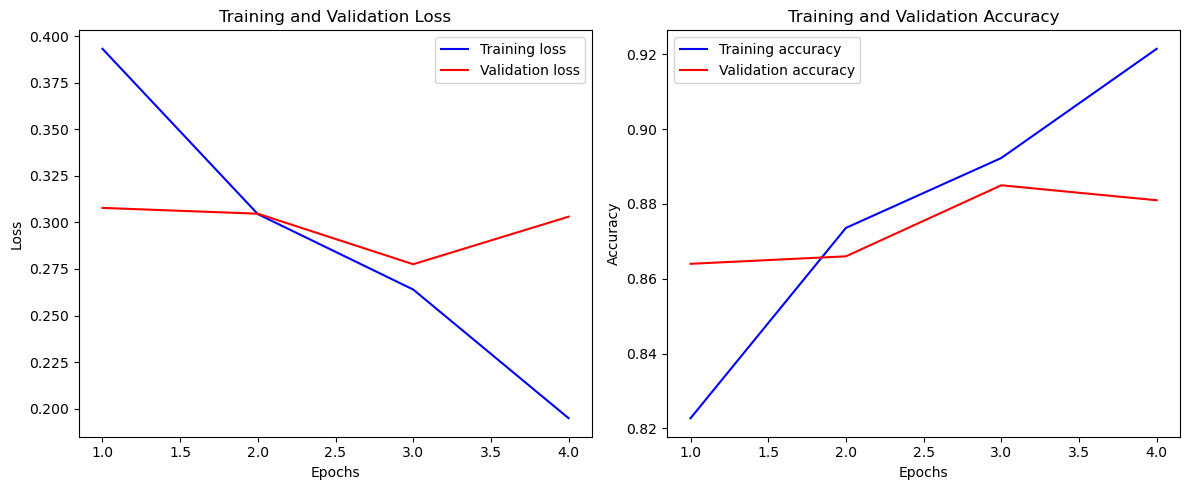

In [90]:
epochs = range(1, EPOCHS + 1)
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


### Saving Model

In [276]:
model_save_path = 'yelp_classifer_model.pth'

torch.save(model.state_dict(), model_save_path)

### Testing the Model

#### Load Model

In [281]:
loaded_model = TransformerSentimentClassifier(vocab_size, embed_dim, num_heads, hidden_dim, num_layers, num_classes, max_length, embedding_matrix)

loaded_model.load_state_dict(torch.load(model_save_path))

loaded_model.to(device)

C:\Users\Airsight\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


TransformerSentimentClassifier(
  (embedding): Embedding(30165, 200)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=200, out_features=200, bias=True)
        )
        (linear1): Linear(in_features=200, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=200, bias=True)
        (norm1): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=200, out_features=2, bias=True)
)

#### Evaluate

In [91]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# evaluate model
model.eval()

# track loss and accuracy
test_loss = 0.0
correct_predictions = 0
total_predictions = 0

# lists to store true and predicted labels for metric calculation
all_labels = []
all_preds = []

# test
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        
        _, preds = torch.max(outputs, 1)
        correct_predictions += (preds == labels).sum().item()
        total_predictions += labels.size(0)
        
        # store true and predicted labels
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# calc average test loss and accuracy
test_loss /= len(test_loader.dataset)
test_accuracy = correct_predictions / total_predictions

# calculate additional metrics
precision = precision_score(all_labels, all_preds, average='binary')
recall = recall_score(all_labels, all_preds, average='binary')
f1 = f1_score(all_labels, all_preds, average='binary')
conf_matrix = confusion_matrix(all_labels, all_preds)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print("Confusion Matrix:")
print(conf_matrix)

Test Loss: 0.2709
Test Accuracy: 88.65%
Precision: 0.89
Recall: 0.94
F1 Score: 0.92
Confusion Matrix:
[[ 505  150]
 [  77 1268]]
